### Imports

In [14]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load and merge data

In [15]:
data_dir = Path("data manipulation")

gen_path = data_dir / "Plant_2_Generation_Data.csv"
wth_path = data_dir / "Plant_2_Weather_Sensor_Data.csv"

# Parse DATE_TIME as datetime directly
df_gen = pd.read_csv(gen_path, parse_dates=["DATE_TIME"])
df_wth = pd.read_csv(wth_path, parse_dates=["DATE_TIME"])

# Inner join on DATE_TIME
df = pd.merge(df_gen, df_wth, on="DATE_TIME", how="inner")

# Drop columns we don't need
df = df.drop(
    columns=["PLANT_ID_x", "SOURCE_KEY_x", "PLANT_ID_y", "SOURCE_KEY_y", "DAILY_YIELD", "TOTAL_YIELD"],
    errors="ignore"
)

print(df.head())
print(df.info())

   DATE_TIME  DC_POWER  AC_POWER  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
0 2020-05-15       0.0       0.0            27.004764           25.060789   
1 2020-05-15       0.0       0.0            27.004764           25.060789   
2 2020-05-15       0.0       0.0            27.004764           25.060789   
3 2020-05-15       0.0       0.0            27.004764           25.060789   
4 2020-05-15       0.0       0.0            27.004764           25.060789   

   IRRADIATION  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            67698 non-null  datetime64[ns]
 1   DC_POWER             67698 non-null  float64       
 2   AC_POWER             67698 non-null  float64       
 3   AMBIENT_TEMPERATURE  67698 non-null  

### Clean and resample

In [16]:
# Remove zero or missing irradiance to avoid divide-by-zero
df_cleaned = df[(df["IRRADIATION"].notna()) & (df["IRRADIATION"] != 0.0)].copy()

# Set index to DATE_TIME and sort
df_cleaned = df_cleaned.set_index("DATE_TIME").sort_index()

# Aggregate to 30-minute intervals
agg_rules = {
    "DC_POWER": "mean",
    "AC_POWER": "mean",
    "AMBIENT_TEMPERATURE": "mean",
    "MODULE_TEMPERATURE": "mean",
    "IRRADIATION": "mean",
}

df_30min = df_cleaned.resample("30Min").agg(agg_rules)

print(len(df))
print(len(df_30min))

67698
1611


### Feature engineering

In [17]:
df_30min["IRRADIANCE_CORRECTED"] = df_30min["IRRADIATION"] * 4000
df_30min["EFFICIENCY"] = df_30min["DC_POWER"] / df_30min["IRRADIANCE_CORRECTED"]

print(df_30min["EFFICIENCY"].describe())

# Temperature difference (module - ambient)
df_30min["TEMP_DELTA"] = df_30min["MODULE_TEMPERATURE"] - df_30min["AMBIENT_TEMPERATURE"]

# Hour of day & day of year
df_30min["HOUR"] = df_30min.index.hour
df_30min["DOY"] = df_30min.index.dayofyear

# Power ratio (inverter performance)
df_30min["POWER_RATIO"] = df_30min["AC_POWER"] / df_30min["DC_POWER"]

# Save engineered dataset (optional)
out_csv = data_dir / "merged_plant2_30min_with_efficiency.csv"
df_30min.to_csv(out_csv, index=True)
print(f"Saved engineered dataset -> {out_csv}")

count    965.000000
mean       0.275676
std        0.115285
min        0.000000
25%        0.211938
50%        0.319726
75%        0.361291
max        0.719899
Name: EFFICIENCY, dtype: float64
Saved engineered dataset -> data manipulation/merged_plant2_30min_with_efficiency.csv


### Prepare data for models

In [18]:
model_df = df_30min.replace([np.inf, -np.inf], np.nan).dropna(
    subset=[
        "EFFICIENCY",
        "IRRADIATION",
        "AMBIENT_TEMPERATURE",
        "MODULE_TEMPERATURE",
        "TEMP_DELTA",
        "HOUR",
        "DOY",
        "POWER_RATIO",
    ]
)

# Ensure sorted by time (chronological)
model_df = model_df.sort_index()

# Features (X) and target (y)
feature_cols = [
    "IRRADIATION",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "TEMP_DELTA",
    "HOUR",
    "DOY",
    "POWER_RATIO",
]
X = model_df[feature_cols]
y = model_df["EFFICIENCY"]

print('effeciency:', model_df["EFFICIENCY"].describe())


# Sequential split - used for time series data

n_samples = len(model_df)
train_idx = int(n_samples * 0.7)  # 70% for training
val_idx = int(n_samples * 0.85)   # 15% for validation (70% + 15% = 85%)
                                   # Remaining 15% for test

X_train = X.iloc[:train_idx]
X_val = X.iloc[train_idx:val_idx]
X_test = X.iloc[val_idx:]

y_train = y.iloc[:train_idx]
y_val = y.iloc[train_idx:val_idx]
y_test = y.iloc[val_idx:]

print(f"Total samples: {n_samples}")
print(f"Train: {len(X_train)} ({len(X_train)/n_samples*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/n_samples*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/n_samples*100:.1f}%)")

print('\nEfficiency Statistics:')
print(f"Train - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"Val   - Mean: {y_val.mean():.4f}, Std: {y_val.std():.4f}")
print(f"Test  - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}")

effeciency: count    877.000000
mean       0.303338
std        0.078901
min        0.014764
25%        0.242189
50%        0.329863
75%        0.363451
max        0.719899
Name: EFFICIENCY, dtype: float64
Total samples: 877
Train: 613 (69.9%)
Validation: 132 (15.1%)
Test: 132 (15.1%)

Efficiency Statistics:
Train - Mean: 0.2954, Std: 0.0780
Val   - Mean: 0.3217, Std: 0.0808
Test  - Mean: 0.3218, Std: 0.0756


### Train all models

In [19]:
# Create pipelines that include scaling
pipelines = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# Train and evaluate (use unscaled X data)
for model_name, pipeline in pipelines.items():
    print(f"\nTraining {model_name}...")
    
    pipeline.fit(X_train, y_train)  # Pipeline handles scaling
    
    y_test_pred = pipeline.predict(X_test)
    
    print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")


Training Linear Regression...
Test R²: 0.4608
Test RMSE: 0.0553

Training Random Forest...
Test R²: 0.6283
Test RMSE: 0.0459

Training Gradient Boosting...
Test R²: 0.5523
Test RMSE: 0.0504


### Evaluate models

In [20]:
pipelines = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# Store results and predictions
results = []
predictions = {}

# Train and evaluate each model (use unscaled X data)
for model_name, pipeline in pipelines.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print('='*60)
    
    # Fit pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict on all sets
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    y_test_pred = pipeline.predict(X_test)
    
    # Store predictions for plotting
    predictions[model_name] = {
        'train': y_train_pred,
        'val': y_val_pred,
        'test': y_test_pred
    }
    
    # Calculate metrics for each set
    for set_name, y_true, y_pred in [
        ('Train', y_train, y_train_pred),
        ('Validation', y_val, y_val_pred),
        ('Test', y_test, y_test_pred)
    ]:
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        
        results.append({
            'Model': model_name,
            'Set': set_name,
            'R²': r2,
            'RMSE': rmse,
            'MAE': mae
        })
        
        print(f"\n{set_name} Set:")
        print(f"  R² Score: {r2:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")

# Create results DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Display summary tables
print("\n" + "="*80)
print("SUMMARY - R² Scores:")
print("="*80)
print(results_df.pivot(index='Model', columns='Set', values='R²').round(4))

print("\n" + "="*80)
print("SUMMARY - RMSE:")
print("="*80)
print(results_df.pivot(index='Model', columns='Set', values='RMSE').round(4))

print("\n" + "="*80)
print("SUMMARY - MAE:")
print("="*80)
print(results_df.pivot(index='Model', columns='Set', values='MAE').round(4))


Training Linear Regression...

Train Set:
  R² Score: 0.5413
  RMSE: 0.0528
  MAE: 0.0358

Validation Set:
  R² Score: 0.5299
  RMSE: 0.0552
  MAE: 0.0387

Test Set:
  R² Score: 0.4608
  RMSE: 0.0553
  MAE: 0.0450

Training Random Forest...

Train Set:
  R² Score: 0.9541
  RMSE: 0.0167
  MAE: 0.0093

Validation Set:
  R² Score: 0.6696
  RMSE: 0.0463
  MAE: 0.0305

Test Set:
  R² Score: 0.6283
  RMSE: 0.0459
  MAE: 0.0316

Training Gradient Boosting...

Train Set:
  R² Score: 0.9224
  RMSE: 0.0217
  MAE: 0.0154

Validation Set:
  R² Score: 0.6132
  RMSE: 0.0501
  MAE: 0.0356

Test Set:
  R² Score: 0.5523
  RMSE: 0.0504
  MAE: 0.0368

SUMMARY - R² Scores:
Set                  Test   Train  Validation
Model                                        
Gradient Boosting  0.5523  0.9224      0.6132
Linear Regression  0.4608  0.5413      0.5299
Random Forest      0.6283  0.9541      0.6696

SUMMARY - RMSE:
Set                  Test   Train  Validation
Model                                       

### Plot Actual vs Predicted Efficiency over Time

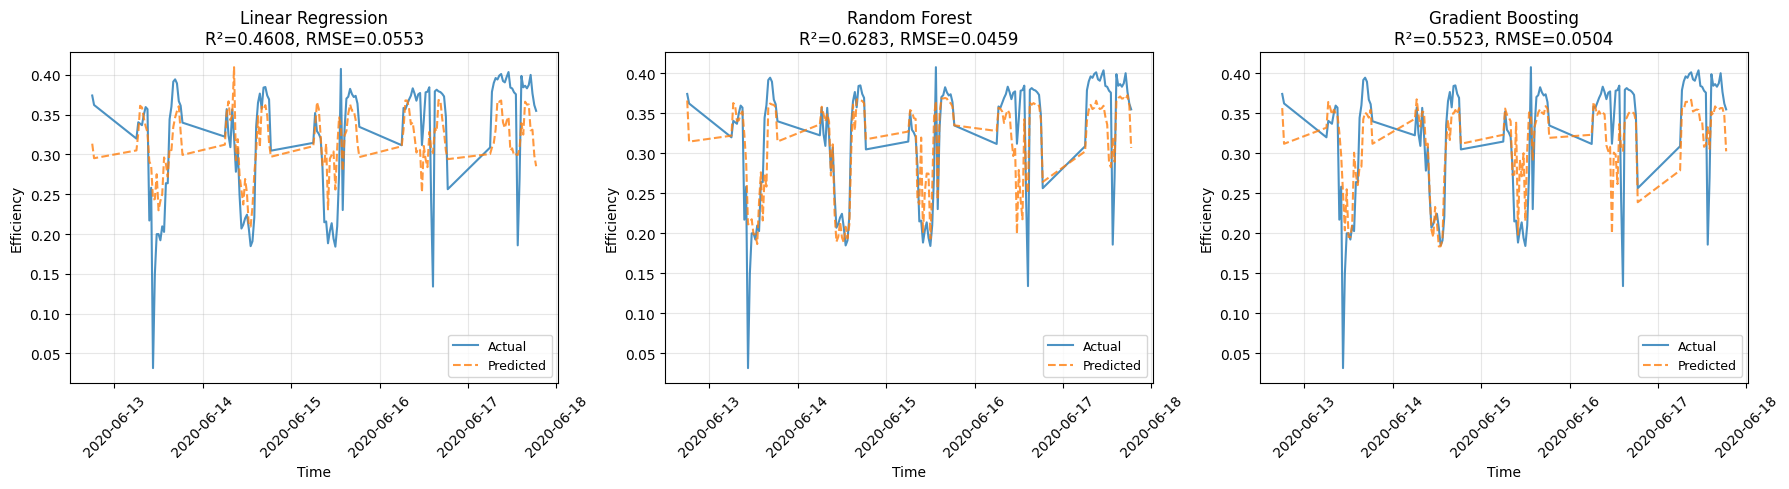

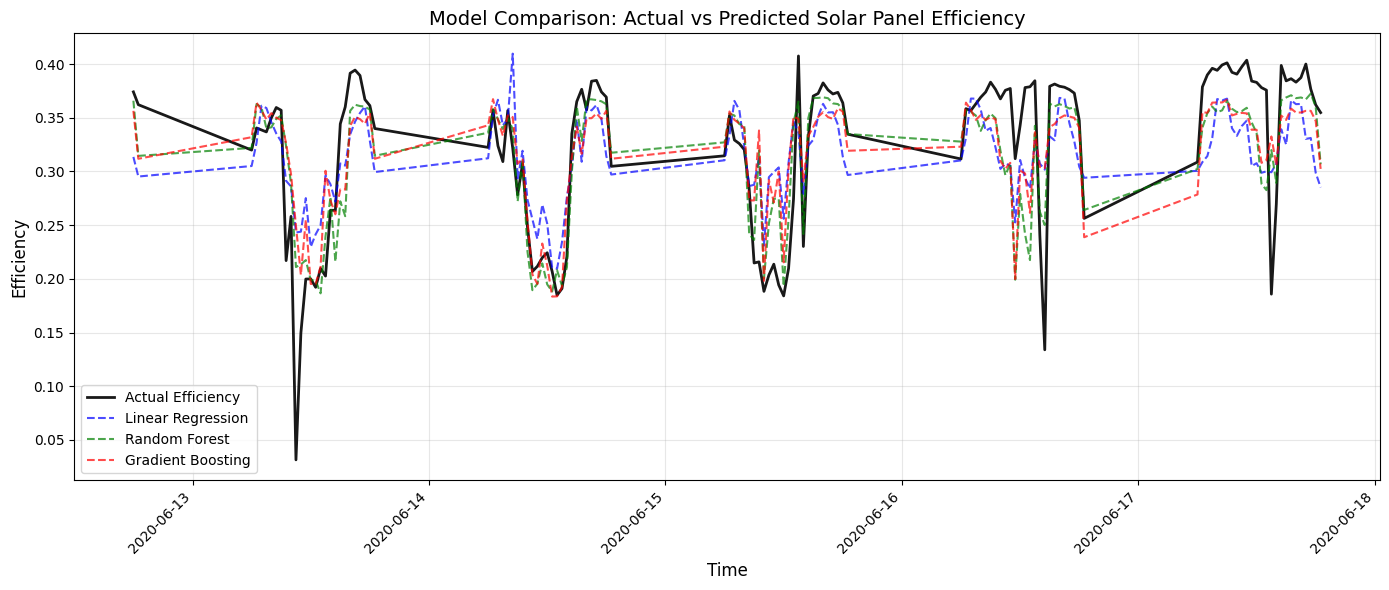

In [21]:
# Plot actual vs predicted for each model on TEST set
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, preds) in enumerate(predictions.items()):
    ax = axes[idx]
    
    # Get test predictions
    y_test_pred = preds['test']
    y_pred_series = pd.Series(y_test_pred, index=y_test.index)
    
    # Plot
    ax.plot(y_test.index, y_test, label="Actual", linewidth=1.5, alpha=0.8)
    ax.plot(y_pred_series.index, y_pred_series, label="Predicted", 
            linestyle="--", linewidth=1.5, alpha=0.8)
    
    # Get metrics for title
    test_results = results_df[(results_df['Model'] == model_name) & 
                              (results_df['Set'] == 'Test')]
    r2 = test_results['R²'].values[0]
    rmse = test_results['RMSE'].values[0]
    
    ax.set_title(f"{model_name}\nR²={r2:.4f}, RMSE={rmse:.4f}", fontsize=12)
    ax.set_xlabel("Time", fontsize=10)
    ax.set_ylabel("Efficiency", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Create a comparison plot - all models on one graph
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label="Actual Efficiency", 
         linewidth=2, alpha=0.9, color='black')

colors = ['blue', 'green', 'red']
for idx, (model_name, preds) in enumerate(predictions.items()):
    y_test_pred = preds['test']
    y_pred_series = pd.Series(y_test_pred, index=y_test.index)
    
    plt.plot(y_pred_series.index, y_pred_series, 
             label=f"{model_name}", 
             linestyle="--", linewidth=1.5, alpha=0.7, color=colors[idx])

plt.xlabel("Time", fontsize=12)
plt.ylabel("Efficiency", fontsize=12)
plt.title("Model Comparison: Actual vs Predicted Solar Panel Efficiency", fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Feature Importance Analysis with Plot



FEATURE IMPORTANCE ANALYSIS

--------------------------------------------------------------------------------
Correlation Analysis: Features vs Efficiency
--------------------------------------------------------------------------------
(Negative correlation = feature contributes to efficiency degradation)
--------------------------------------------------------------------------------
  IRRADIATION         : -0.6505  ↓ DEGRADATION
  TEMP_DELTA          : -0.6445  ↓ DEGRADATION
  MODULE_TEMPERATURE  : -0.5764  ↓ DEGRADATION
  AMBIENT_TEMPERATURE : -0.2612  ↓ DEGRADATION
  DOY                 :  0.1465  ↑ EFFICIENCY
  POWER_RATIO         :  0.1393  ↑ EFFICIENCY
  HOUR                :  0.1161  ↑ EFFICIENCY

--------------------------------------------------------------------------------
Average Feature Importance (Random Forest + Gradient Boosting)
--------------------------------------------------------------------------------
(Higher value = feature has more impact on efficiency predi

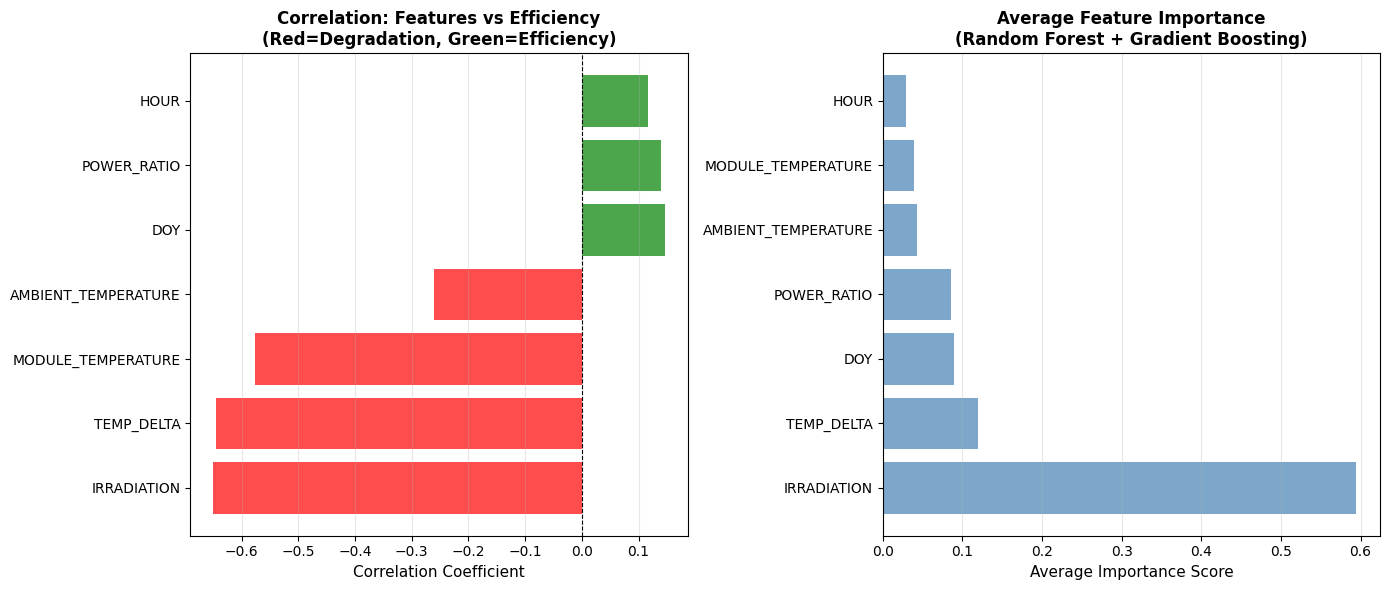

In [ ]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get the trained models from pipelines (already trained in section 6)
trained_models = {}
for model_name, pipeline in pipelines.items():
    trained_models[model_name] = pipeline

# 1. Correlation Analysis with Efficiency (most direct way to identify degradation)
print("\n" + "-"*80)
print("Correlation Analysis: Features vs Efficiency")
print("-"*80)
print("(Negative correlation = feature contributes to efficiency degradation)")
print("-"*80)

correlations = model_df[feature_cols + ['EFFICIENCY']].corr()['EFFICIENCY'].drop('EFFICIENCY')
correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

for feature, corr in correlations.items():
    direction = "↓ DEGRADATION" if corr < 0 else "↑ EFFICIENCY"
    print(f"  {feature:20s}: {corr:7.4f}  {direction}")

# 2. Average Feature Importance from Tree-Based Models (most reliable)
rf_model = trained_models['Random Forest'].named_steps['model']
gb_model = trained_models['Gradient Boosting'].named_steps['model']

rf_importance = pd.Series(rf_model.feature_importances_, index=feature_cols)
gb_importance = pd.Series(gb_model.feature_importances_, index=feature_cols)

avg_importance = (rf_importance + gb_importance) / 2
avg_importance = avg_importance.sort_values(ascending=False)

print("\n" + "-"*80)
print("Average Feature Importance (Random Forest + Gradient Boosting)")
print("-"*80)
print("(Higher value = feature has more impact on efficiency prediction)")
print("-"*80)

for feature, importance in avg_importance.items():
    print(f"  {feature:20s}: {importance:7.4f}")

# 3. Summary: Top features contributing to degradation
print("\n" + "="*80)
print("SUMMARY: Features Contributing to Efficiency Degradation")
print("="*80)

degradation_features = correlations[correlations < 0].sort_values()
if len(degradation_features) > 0:
    print("\nFeatures with NEGATIVE correlation (contribute to degradation):")
    for feature, corr in degradation_features.items():
        print(f"  {feature:20s}: {corr:7.4f}")
else:
    print("\nNo features show negative correlation with efficiency.")

# 4. Visualize: Combined Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation plot
ax = axes[0]
colors_corr = ['red' if x < 0 else 'green' for x in correlations.values]
ax.barh(correlations.index, correlations.values, color=colors_corr, alpha=0.7)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Correlation Coefficient', fontsize=11)
ax.set_title('Correlation: Features vs Efficiency\n(Red=Degradation, Green=Efficiency)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Average importance plot
ax = axes[1]
ax.barh(avg_importance.index, avg_importance.values, color='steelblue', alpha=0.7)
ax.set_xlabel('Average Importance Score', fontsize=11)
ax.set_title('Average Feature Importance\n(Random Forest + Gradient Boosting)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()
